# <center> Notes on option pricing </center>

This notebook is about how to use python to price European option, which is focusing on two methods: closed form European call option pricing -- Black Scholes Merton option model and Monte Carlo-based method. They are shown in Section 1 and Section 3. Section 2 is focusing on the calculation and visualization of Greeks, analyzing how option prices and other quantities of interest react to changes in the model parameters.

### 1. BSM for European option

We assume that the price of a stock follows the geometric Brownian motion process described by Black-Scholes-Merton. The stock has a starting price $S_0$. The risk-free interest rate $r$ represent the time value of money. Stock volatility $\sigma$ describes how quickly the stock price moves. The call option is an option to buy at a strike price $K$ expiring at maturity time $T$. 

Against this background, we model the risk-neutral evolution of the relevant stock price as

$$dS_t=S_t(rdt + \sigma dW_t)$$

where, $0\leq t\leq T$, $W_t$ is a standard Brownian modtion.

Then, the price at time $T$ is given by 

$$S_t=S_0 e^{(r-\frac{1}{2}\sigma^2)t + \sigma \sqrt{t} Z}$$

where, $Z$ is a random variable that has a standard normal distribution (mean zero, variance one).

Denote the value at time t of a European call option on the index $S$ as $C(S_t,t)$, with payoff $e^{-r(T-t)}(S_T-K)^+$. One can finally show that,

$$
C(S_t,t) = S_t\Phi(d_1)- Ke^{-r(T-t)}\Phi(d_2)
$$

where
\begin{align*}
\Phi(d) &= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^d e^{-\frac{1}{2}x^2}dx\\
d_1&=\frac{\log{\frac{S_t}{K} + (r+\frac{\sigma^2}{2})(T-t)}}{\sigma\sqrt{T-t}}\\
d_2&=\frac{\log{\frac{S_t}{K} + (r-\frac{\sigma^2}{2})(T-t)}}{\sigma\sqrt{T-t}}
\end{align*}

To derive the corresponding formula for a European put option, one can apply put-call parity:

$$C_t-P_t=S_t-e^{-r(T-t)}K$$.

Then, we have price for European put option:
$$P(S_t,t)=Ke^{-r(T-t)}\Phi(-d_2)-S_t\Phi(-d_1)$$

In the following, we analyze an example Eurorean option with the parameters: $S_0=100,K=100,T=1,r=0.05,\sigma=0.2,t=0$.

In [48]:
#
# Black-Scholes-Merton (1973) European Call & Put Valuation
# 
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad
%matplotlib inline

#
# Define helper functions
#

# Probability density function of standard normal random variable z
def pNormal(z):
    return math.exp(-0.5*z**2)/math.sqrt(2*math.pi)

# Cumulative density function of standard normal random varaible z
def cNormal(z):
    return quad(lambda x: pNormal(x), -20, z, limit=50)[0]

# BSM d1 function (parameters see function BSM_call_value)
def d1f(St, K, t, T, r, sigma):
    d1 = (math.log(St/K) + (r+0.5*sigma**2)*(T-t)) / (sigma*math.sqrt(T-t))
    return d1

#
# BSM valuation functions
#

# Calculates BSM European call option value
def BSM_call_value(St, K, t, T, r, sigma):
    '''
    Parameters:
        St: float, stock/index level at time t
        K: float, strike price
        t: float, valuation date
        T: float, data of maturity, T>t
        r: float, constant, risk-free interest rate
        sigma: float, valatility
    Outputs:
        call_value: float, European call value at time t
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T-t)
    call_value = St * cNormal(d1) - math.exp(-r*(T-t))*K*cNormal(d2)
    return call_value


# Calculates BSM European put option value
def BSM_put_value(St, K, t, T, r, sigma):
    '''
    Parameters:
        same as in function BSM_call_value
    Outputs:
        put_value: float, European put value at time t
    '''
    put_value = BSM_call_value(St, K, t, T, r, sigma) - St + math.exp(-r*(T-t))*K
    return put_value

#
# Plotting European Option Values
#
def plot_values(function):
    ''' Plots European option values for different parameters c.p. '''
    plt.figure(figsize=(10, 8.3))
    points = 100
    #
    # Model Parameters
    #
    St = 100.0  # index level
    K = 100.0  # option strike
    t = 0.0  # valuation date
    T = 1.0  # maturity date
    r = 0.05  # risk-free interest rate
    sigma = 0.2  # volatility
    # C(K) plot
    plt.subplot(221)
    klist = np.linspace(80, 120, points)
    vlist = [function(St, K, t, T, r, sigma) for K in klist]
    plt.plot(klist, vlist)
    plt.grid()
    plt.xlabel('strike $K$')
    plt.ylabel('present value')
    # C(T) plot
    plt.subplot(222)
    tlist = np.linspace(0.0001, 1, points)
    vlist = [function(St, K, t, T, r, sigma) for T in tlist]
    plt.plot(tlist, vlist)
    plt.grid(True)
    plt.xlabel('maturity $T$')
    # C(r) plot
    plt.subplot(223)
    rlist = np.linspace(0, 0.1, points)
    vlist = [function(St, K, t, T, r, sigma) for r in rlist]
    plt.plot(tlist, vlist)
    plt.grid(True)
    plt.xlabel('interest rate $r$')
    plt.ylabel('present value')
    plt.axis('tight')
    # C(sigma) plot
    plt.subplot(224)
    slist = np.linspace(0.01, 0.5, points)
    vlist = [function(St, K, t, T, r, sigma) for sigma in slist] 
    plt.plot(slist, vlist)
    plt.grid(True)
    plt.xlabel('volatility $\sigma$')
    plt.tight_layout()

The following plots shows variations of call option value with respect to a single parameter only. 

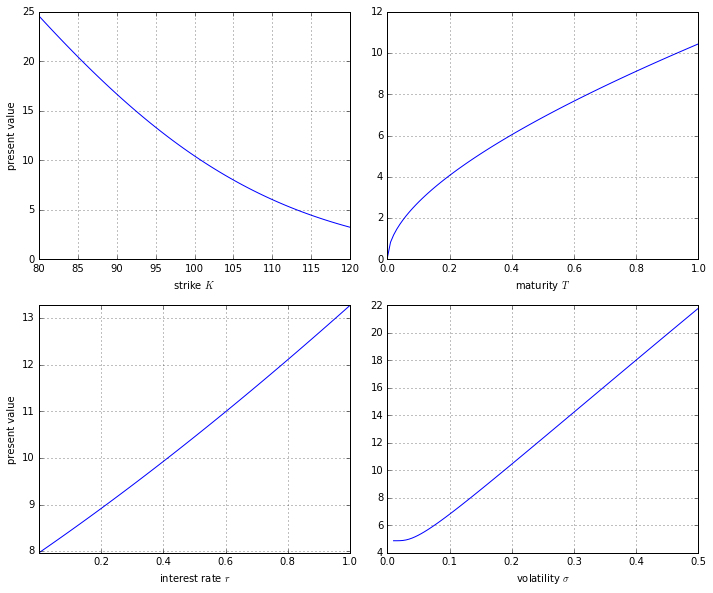

In [49]:
plot_values(BSM_call_value)

###  2. Greeks in the BSM model

In particular for hedging and risk management purpose, it is of importance to know how option values change with marginal changes in the model parameter. From the famous BSM partial differential equation:

$$\frac{\partial C}{\partial S} + \frac{1}{2}\sigma^2S^2\frac{\partial^2C}{\partial S^2}+\frac{\partial C}{\partial t} = rC$$

The closed-form valuation formula in Section 1 allows expressions to be derived for the most important Greeks:

\begin{align*}
\Delta &= \frac{\partial C}{\partial S} = \Phi(d_1)\\
\Gamma &= \frac{\partial^2 C}{\partial S^2} = \frac{\phi(d_1)}{S_t\sigma\sqrt{T-t}}\\
\Theta &= \frac{\partial C}{\partial t} = -\frac{S_t\phi(d_1)\sigma}{2\sqrt{T-t}} - re^{-r(T-t)}K\Phi(d_2)\\
\rho &= \frac{\partial C}{\partial r} = K(T-t)e^{-r(T-t)}\Phi(d_2)\\
\nu &= \frac{\partial C}{\partial \sigma} = S\phi(d_1)\sqrt{T-t}
\end{align*}

In [10]:
# 
# Black-Scholes-Merton (1973) European Call Option Greeks
#
import mpl_toolkits.mplot3d.axes3d as p3

#
# Functions for Greeks
#

# BSM DELTA of European call option
def BSM_delta(St, K, t, T, r, sigma):
    '''
    Parameters:
        same as in function BSM_call_value
    Outputs:
        delta: float, European call option DELTA
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    delta = cNormal(d1)
    return delta

# BSM GAMMA of European call option
def BSM_gamma(St, K, t, T, r, sigma):
    '''
    Parameters:
        same as in function BSM_call_value
    Outputs:
        gamma: float, European call option GAMMA
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    gamma = pNormal(d1) / (St * sigma * math.sqrt(T - t))
    return gamma

# BSM THETA of European call option
def BSM_theta(St, K, t, T, r, sigma):
    '''
    Parameters:
        same as in function BSM_call_value
    Outputs:
        gamma: float, European call option THETA
    '''
    
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    theta = -(St * pNormal(d1) * sigma / (2 * math.sqrt(T - t))
             + r * K * math.exp(-r * (T - t)) * cNormal(d2))
    return theta

# BSM RHO of European call option
def BSM_rho(St, K, t, T, r, sigma):
    '''
    Parameters:
        same as in function BSM_call_value
    Outputs:
        gamma: float, European call option RHO
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    rho = K * (T - t) * math.exp(-r * (T - t)) * cNormal(d2)
    return rho

# BSM Vega of European call option
def BSM_vega(St, K, t, T, r, sigma):
    '''
    Parameters:
        same as in function BSM_call_value
    Outputs:
        gamma: float, European call option VEGA
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    vega = St * pNormal(d1) * math.sqrt(T - t)
    return vega


#
# Plotting the Greeks
#
def plot_greeks(function, greek):
    # Model Parameters
    St = 100.0  # index level
    K = 100.0  # option strike
    t = 0.0  # valuation date
    T = 1.0  # maturity date
    r = 0.05  # risk-free interest rate
    sigma = 0.2  # volatility
    # Greek Calculations
    tlist = np.linspace(0.01, 1, 25)
    klist = np.linspace(80, 120, 25)
    V = np.zeros((len(tlist), len(klist)), dtype=np.float)
    for j in range(len(klist)):
        for i in range(len(tlist)):
            V[i, j] = function(St, klist[j], t, tlist[i], r, sigma)
    # 3D Plotting
    x, y = np.meshgrid(klist, tlist)
    fig = plt.figure(figsize=(9, 5))
    plot = p3.Axes3D(fig)
    plot.plot_wireframe(x, y, V)
    plot.set_xlabel('strike $K$')
    plot.set_ylabel('maturity $T$')
    plot.set_zlabel('%s(K, T)' % greek)

In the following, I plot all the Greeks with different time-to-maturities T and different strikes K. Some obervations are worth pointing out:

1) $\Delta$ changes most around $K=100$ for short maturities.

2) $\Gamma$ has the highest values around $K=100$ for short maturities. This is in line with the first observation.

3) $\Theta$ has similar pattern with gamma but with changed sign.

4) $\rho$ increases with longer time-to-maturity and with lower strike price.

5) $\nu$ increases with T and decreases from $K=100$ in both directions.

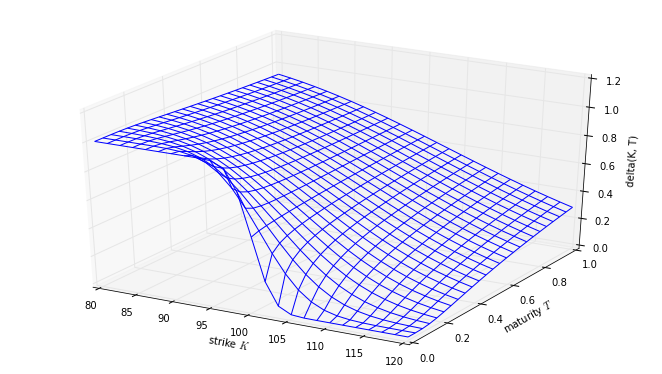

In [50]:
plot_greeks(BSM_delta,'delta')

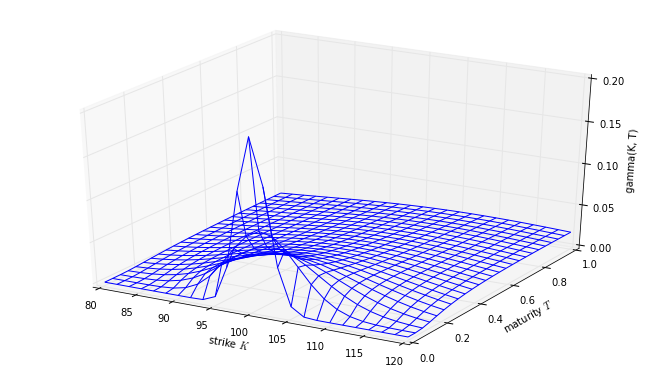

In [51]:
plot_greeks(BSM_gamma,'gamma')

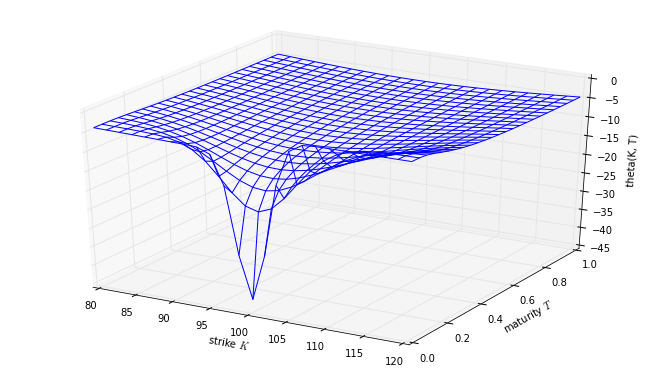

In [52]:
plot_greeks(BSM_theta,'theta')

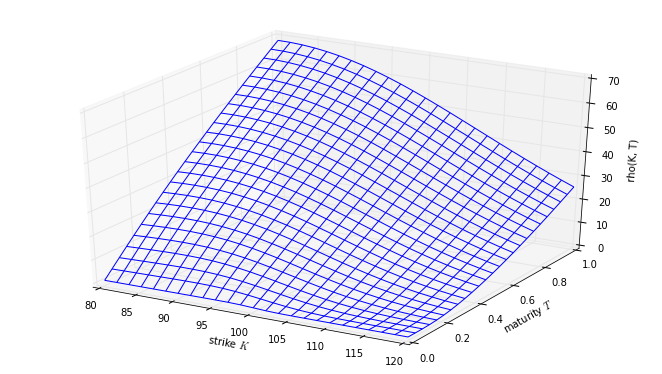

In [53]:
plot_greeks(BSM_rho,'rho')

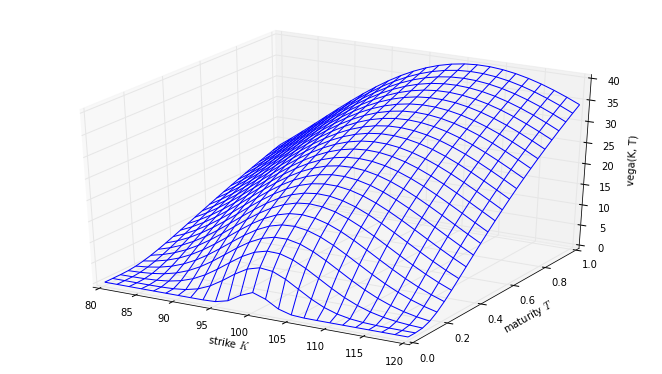

In [54]:
plot_greeks(BSM_vega,'vega')

### 3. Monte Carlo simulation

Monte Carlo simulation is a rather flexible valuation approach which is capable of much more than classical model. It is applicable to almost any feature a financial product can exhibit. The Black Scholes model describes one way of determining a fair price for an option, but we can also use Monte Carlo simulation for determing a price.

Take European call option pricing as an example. As illustrated in first section, the value at time t of a European call option on the index $S$, 

$$C(S_t,t)=E[e^{-r(T-t)}(S_T-K)^+|\mathcal{F}_t].$$ 

To price an option using a Monte Carlo simulation, we use a risk-neutral valuation, where the fair value for a derivative is the expected value of its future payoff. Then, we are going to create a simulation that provides us with many observations for the final price of the asset $S_T$. By averaging all of the pay offs, we are provided with a value for our expectation of the payoff.

The model of stock price behaviour used in the Black Scholed model assumes that we have a known volatility, we have a risk-free interest rate, and that the price of  an asset follows a geometric Brownian motion. So now we have a method for calculating asset prices at time $T$:

$$S_T=S_t\exp{\{(r-\frac{1}{2}\sigma^2)(T-t)+\sigma\sqrt{T-t}z\}},$$

where, $z$ is standard normal random variable.

To price an option in this simulation, the steps are:

1) generate $M$ simulations of the asset prices $S_T^{(m)},m=1,...,M$.

2) calculate option payoffs for each of generated price $(S_T^{(m)}-K)^+$.

3) Average over the payoffs and discount the final value
$$C_{mc}=\frac{1}{M}\sum_{m=1}^Me^{-r(T-t)}(S_T^{(m)}-K)^+.$$

In [46]:
# 
# Pricing European call option using Monte Carlo simulation
# The parameters are same as in BSM_call_value
#

# Function for generating asset price, following geometric Brownian motion
def generate_asset_price(St,t,T,r,sigma):
    return St * math.exp((r - 0.5 * sigma**2) * (T-t) + sigma * math.sqrt(T-t) * np.random.standard_normal(1))

# Function for calculating payoff
def call_payoff(ST, K):
    return max(ST - K, 0.0)

St = 100.0  # index level
K = 100.0  # option strike
t = 0.0  # valuation date
T = 1.0  # maturity date
r = 0.05  # risk-free interest rate
sigma = 0.2  # volatility

simulations = 10000
payoffs = []
discount_factor = math.exp(- r * (T-t))

for i in range(simulations):
    ST = generate_asset_price(St,t,T,r,sigma)
    payoffs.append(
        call_payoff(ST, K)
    )

mc_price = discount_factor * (sum(payoffs) / float(simulations))
bsm_price = BSM_call_value(St, K, t, T, r, sigma)

Comparing the result of option price by using Black Scholes model and Monte Carlo simulation:

In [47]:
print ('Price using Black Scholes Model: %.4f' % bsm_price)
print ('Price using Monte Carlo: %.4f' % mc_price)

Price using Black Scholes Model: 10.4506
Price using Monte Carlo: 10.7092
